# Redes convolucionales

## Capas convolucionales

Cuando clasificamos imágenes, la forma más simple de abordarlas es entender cada pixel como una *feature* de entrada, siendo la salida de nuestro modelo la clasificación de la imagen en función del conjunto de píxeles. Esto se vuelve muy ineficiente cuando la imagen es muy grande, ya que la cantidad de parámetros que se deben aprender es muy grande. Además, la información relevante de una imagen no es solo el valor de cada pixel, sino también las relaciones entre los mismos; píxeles cercanos suelen conformar características más complejas que píxeles lejanos.

Las redes convolucionales son una forma de abordar este problema, ya que permiten reducir la cantidad de parámetros a aprender, al mismo tiempo que se mantiene la información relevante de la imagen. Esto se logra a través de la utilización de filtros que se aplican a la imagen, de forma que se extraen características relevantes de la misma.

Una capa convolucional en una red neuronal actua como una ventana (o filtro) que se desplaza por la imagen escaneando conjuntos de píxeles cercanos y buscando un patrón especifico en ellos. De este modo, se hace un primer paso de búsqueda de *features* de mayor abstracción, que luego son utilizadas por las capas siguientes para realizar la clasificación.

Las capas convolucionales están diseñadas para manejar datos con un alto grado de correlación espacial. Son muy comunes siempre que se trabaja con imágenes, como en visión artificial, pero también aparecen en otros contextos, como en aplicaciones de **procesamiento de lenguaje natural (*Natural Language Processing*, NLP)**, donde el contexto inmediato de una palabra (es decir, el orden de las palabras) es determinante para su significado.


- [Dot CSV - ¡Redes Neuronales CONVOLUCIONALES! ¿Cómo funcionan?](https://www.youtube.com/watch?v=V8j1oENVz00&ab_channel=DotCSV)
- [Dot CSV - ¡Extraños Patrones dentro de una RED NEURONAL!](https://www.youtube.com/watch?v=ysqpl6w6Wzg&ab_channel=DotCSV)
- [Convolución y filtrado de imágenes](https://programmerclick.com/article/5690865983/)

## Ejemplo de detección de bordes en una imagen

Podemos ver un código simple que aplica un filtro de detección de bordes a una imagen. Los bordes detectados son aquellos en los que hay un cambio brusco en la intensidad de los píxeles de la imagen. Es un ejemplo de lo que se puede hacer en las primeras capas de una red convolucional para detectar características de la imagen.

Podemos intuir que los bordes son una característica importante para la clasificación de imágenes.

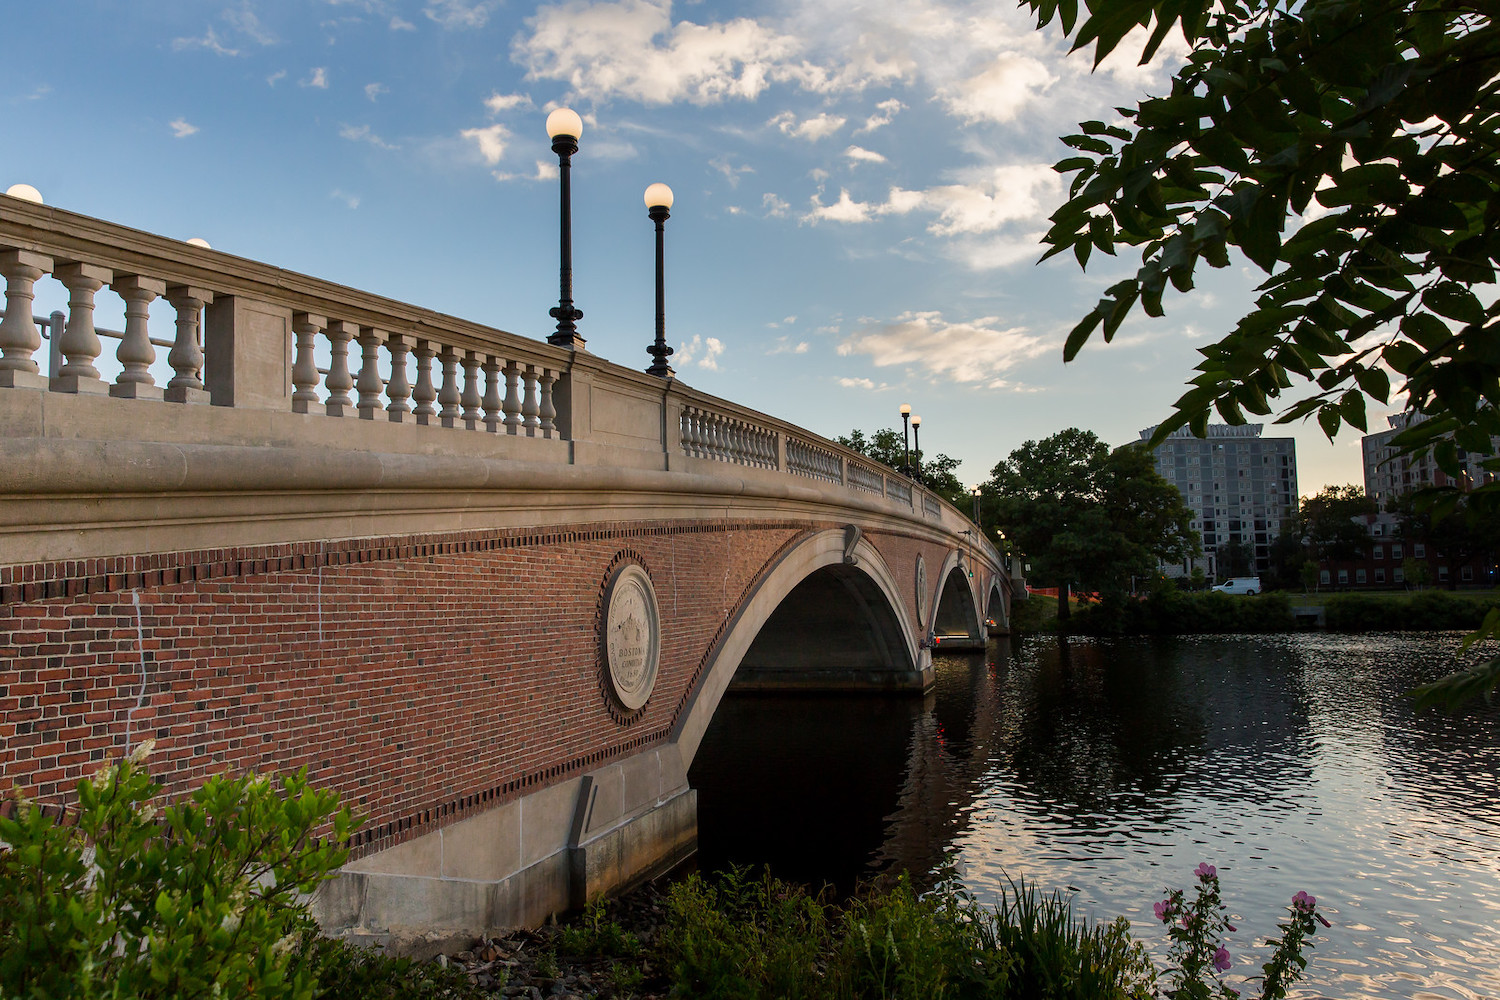

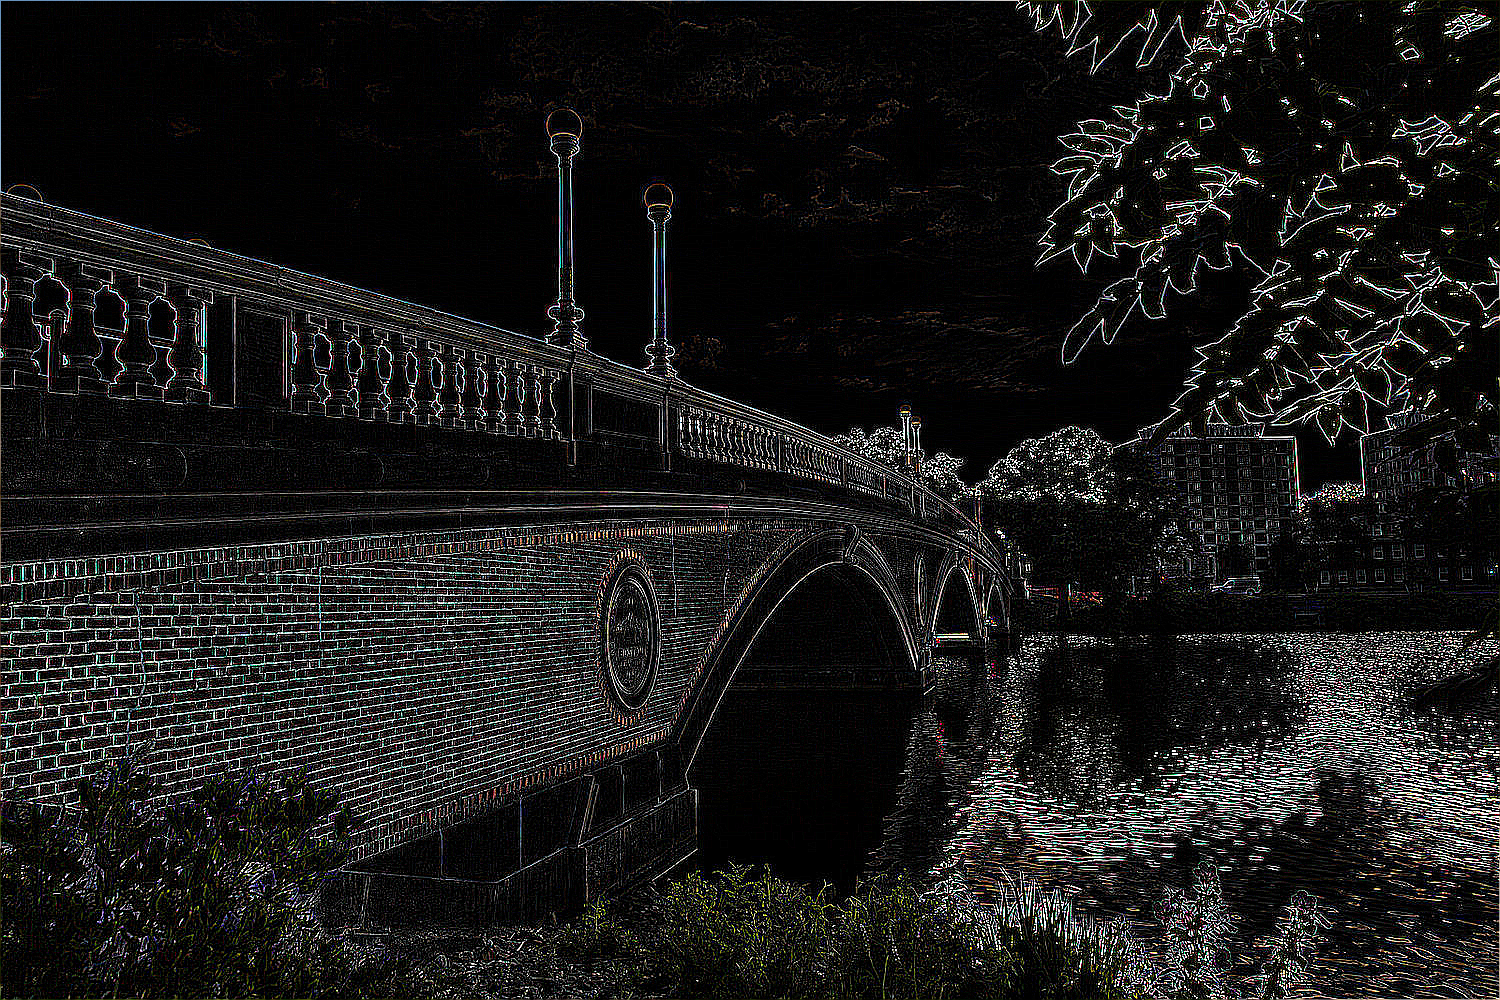

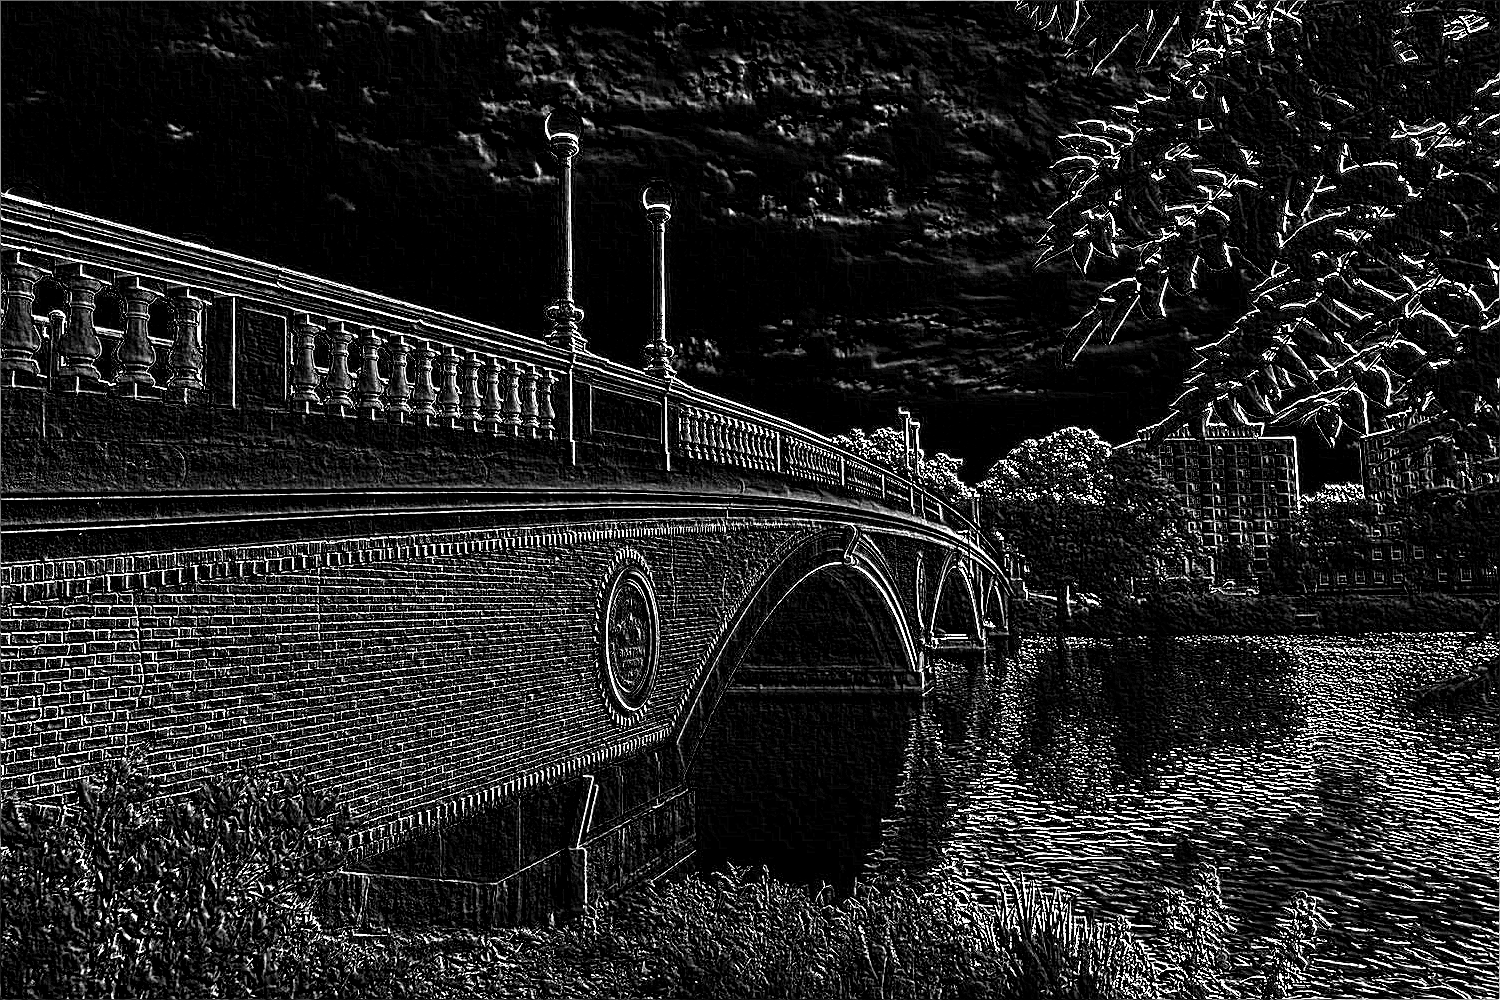

In [3]:
from PIL import Image, ImageFilter
from IPython.display import display

image_path = "img/bridge.png"
image = Image.open(image_path).convert("RGB")
display(image)

filtered_image = image.filter(ImageFilter.Kernel(
    size=(3, 3), # Tamaño del kernel (la ventana)
    kernel=[-1, -1, -1, -1, 8, -1, -1, -1, -1], # Valores de la ventana. Máscara de convulsion, la idea es que sea un filtro de detección de bordes (llamado Laplaciano). SI sumo todos los valores de la máscara, el resultado es 0, por lo que no hay cambio de brillo y sol oresalto los bordes. 
    scale=1 # Escala de la máscara, indica como se deben normalizar los valroes del resultado del filtro. En este caso, no se normaliza porque la suma de los valores de la máscara es 0. 
))
display(filtered_image)

r, g, b = image.split()
r_filtered = r.filter(ImageFilter.Kernel(
    (3,3), 
    [-1]*8 + [8],
    scale=1))
# Mostrar el canal rojo filtrado 
display(r_filtered)

## [Capas convolucionales en Pytorch](https://pytorch.org/docs/stable/nn.html#convolution-layers)

In [ ]:
import torch
import torch.nn.functional as F 

class LeNet(torch.nn.Module): # Arquitectura LeNet

    def __init__(self):
        super().__init__()
        # 1 input image channel (black & white), 6 output channels, 5x5 square convolution kernel
        self.conv1 = torch.nn.Conv2d(1, 6, 5)
        self.conv2 = torch.nn.Conv2d(6, 16, 3) # Esto suelta un mapa de activacion de 16 canales x 12 x 12
        self.fc1 = torch.nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x)) # Aplana la matriz, de aquí sale el 16 * 6 * 6 que se pasa a la capa fully connected 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x): # Calcula cuántos valores hay en el tensor (excepto el primer eje, que es el tamaño del batch) para poder aplanarlo correctamente
        size = x.size()[1:]  # Quita la parte de batch_size y da 16 * 6 * 6 = 576 
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

En este caso, se utiliza la librería [`nn.functional`](https://pytorch.org/tutorials/beginner/nn_tutorial.html#using-torch-nn-functional) para poder llamar a las funciones de activación directamente. Es otro estilo de programación. En ambos casos se las llama desde `forward`, pero la diferencia es que en este caso no se necesita crear un atributo de la clase `nn.ReLU()` en el contructor. Lo mismo aplica para la función `nn.max_pool2d()`.

La primera capa (`torch.nn.Conv2d(1, 6, 5)`) realizará una **convolución** de 2 dimensiones sobre la imagen de entrada. Esta capa espera un tensor de entrada de 1x6x5:
- El primer argumento es el **número de canales** de entrada. Aquí, es 1 esperando imágenes en blanco y negro. Si estuviéramos construyendo este modelo para ver 3 canales de color (RGB), sería 3.
- El segundo argumento son los los patrones que se busca encontrar al aplicar la capa convolucional y que servirán de ***features*** de la siguiente capa. En este caso le pedimos a la capa que aprenda 6 características de la imagen; la capa usará 6 filtros.
- El tercer argumento es el tamaño de la **ventana (*window*)** o ***kernel***. Aquí, 5 significa que usaremos una ventana de 5x5.

La salida de una capa convolucional es un mapa de activación (***activation map***), una representación espacial de la presencia de características en el tensor de entrada. La salida será un tensor de 6x28x28. 6 es el número de *features* que le hemos pedido que busque, y 28 es la altura y anchura del mapa. El 28 viene de que al escanear con una ventana de 5x5 sobre una fila de 32, solo hay 28 posiciones posibles (2 filas originales por arriba y por abajo desaparecen.). QUE PERDEMOS HUECOS POR HACER 32 (tamaño original de la img) -5 (el kerner es 5x5) + 1 (que siemrpe está ahi, matemáticas), LO QUE ES IGUAL A LA SALIDA DE [batch_size, 6, 28,28]. DESPUES VA A RELU + POOLING COMO DICE ABAJO [donde baja a 6x14x14], Y LUEGO A LA SIGUIENTE CAPA CONVOLUCIONAL

Esta capa se pasa a través de una **función de activación ReLU** (en la función forward) y luego a través de una capa de ***max pooling***.

La capa de *max pooling* toma las características cercanas en el mapa de activación y las agrupa. Lo hace reduciendo el tensor, fusionando cada grupo de 2x2 celdas en una sola celda y asignando a esa celda el valor máximo de las 4 celdas que la componen. Esto nos da una versión de menor resolución del mapa de activación, con dimensiones 6x14x14.

[![](img/MaxpoolSample2.png)](https://computersciencewiki.org/index.php?title=Max-pooling_/_Pooling)

La siguiente capa convolucional, `conv2`, espera 6 canales de entrada (correspondientes a las 6 características buscadas por la primera capa), tiene 16 canales de salida y un kernel de 3x3. Produce un mapa de activación de 16x12x12, que nuevamente se reduce mediante una capa de *max pooling* a 16x6x6. Antes de pasar esta salida a las capas lineales, se remodela a un vector de 16 \* 6 \* 6 = 576 elementos para ser consumido por la siguiente capa.

## Fuentes

- https://cs50.harvard.edu/ai/2024/weeks/5/
- https://pytorch.org/tutorials/beginner/introyt/modelsyt_tutorial.html
- https://medium.com/thedeephub/convolutional-neural-networks-a-comprehensive-guide-5cc0b5eae175
- https://www.pinecone.io/learn/series/image-search/cnn/
- https://stackoverflow.com/questions/65554032/understanding-convolutional-layers-shapes
- https://dudeperf3ct.github.io/cnn/mnist/2018/10/17/Force-of-Convolutional-Neural-Networks/
- https://poloclub.github.io/cnn-explainer/